# Introduction

Here, I explore how different unsupervised ML algorithms cluster datasets with different structures. 

To do so, I use three different datasets consisting of points in a two dimensional space. Each point has an associated class which will serve to evaluate the performance of each clustering algorithm. 

Each dataset contains 1000 data points, each of them belonging to one of either 2 or 4 clases.

Each clustering algorithm has its own nuances which make it better in certain cases and worse in others. Along with the execution of the algorithms I will explain these nuances and how they affect the performance of the algorithm.

There is a "environment.yaml" file with the required packages and versions in this repository.

This notebook derives from exercises performed in the Data Science MSc by UOC.

In [1]:
import random

import tqdm
import umap
import numpy as np
import pandas as pd

# Clustering-related
import sklearn
from sklearn import cluster        
from sklearn import datasets       
from sklearn import decomposition

# Visualization-related
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline

## Generation of datasets

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

list_vars = [X_blobs, y_blobs, X_moons, y_moons, X_circles, y_circles]
list_var_names = ["X_blobs", "y_blobs", "X_moons", "y_moons", "X_circles", "y_circles"]

for el in range(len(list_vars)):
    print("Dimensions of "+ list_var_names[el]+": "+ str(list_vars[el].shape))

for el in [1, 3, 5]:
    print("Number of unique elements in "+list_var_names[el][2:]+": "+str(len(np.unique(list_vars[el]))))

Dimensions of X_blobs: (1000, 2)
Dimensions of y_blobs: (1000,)
Dimensions of X_moons: (1000, 2)
Dimensions of y_moons: (1000,)
Dimensions of X_circles: (1000, 2)
Dimensions of y_circles: (1000,)
Number of unique elements in blobs: 4
Number of unique elements in moons: 2
Number of unique elements in circles: 2


We have 3 datasets ("Blobs", "Moons" and "Circles") each of them containing 1000 points. In the Blobs dataset we have 4 clases, whereas in the Moons and in the Circles dataset we have 2 clases.

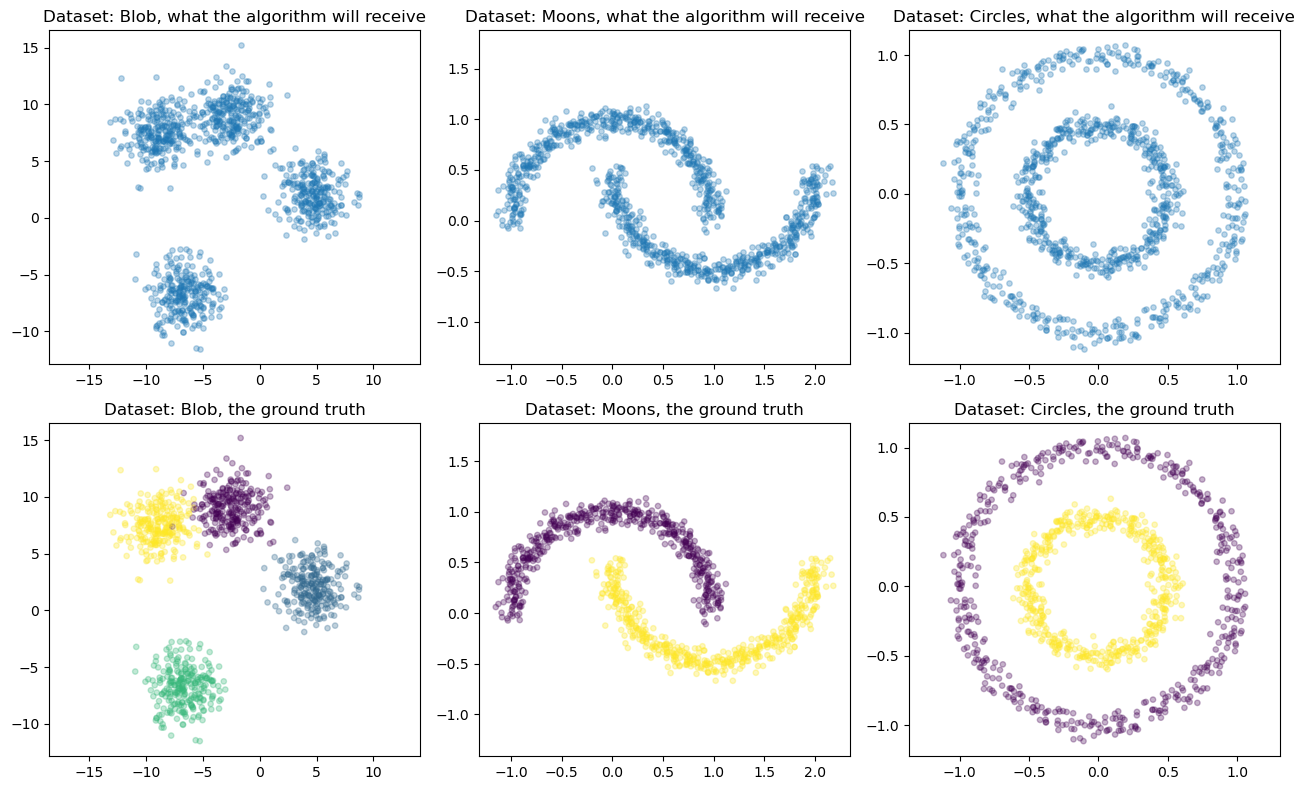

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('what the algorithm will receive' if i < 3 else 'the ground truth'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3)
    ax.axis('equal')
plt.tight_layout()

## 1.1 K-Means

*K-means* works by separating data points into a user-defined number (*k*) of clusters. Data points are assigned to specific cluster by computing the distance (there are different distance metrics) to cluster centroids, and iteratively re-locate the centroids until convergence is reached. The main difficulty when applying this algorithm consists in determining the correct number of clusters. It is important to remember that this an unsupervised learning algorithm, so the previous knowledge about the dataset might not be enough to make the choice of a number of clusters trivial. 

To help with determining the appropriate number of clusters, one common approach is to perform the K-means process a number of times, each of them with a different amount of clusters. For each number of clusters, the sum of the squared errors (SSE) is calculated by measuring the distance from each point to its centroid. By plotting the number of clusters vs its associated SSE the so-called *elbow plot* is generated. The number of clusters at which the reduction in SSE starts to be slower, or *elbow*, is the value of *K* to begin with. Here the formula for the SSE:

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

## 1.1.1. K-Means with the Blobs dataset

For each dataset, I will generate the elbow plot for the K-means and then run the algorithm with the elbow value for the *K* parameter.

Here the elbow plot for the Blobs dataset:

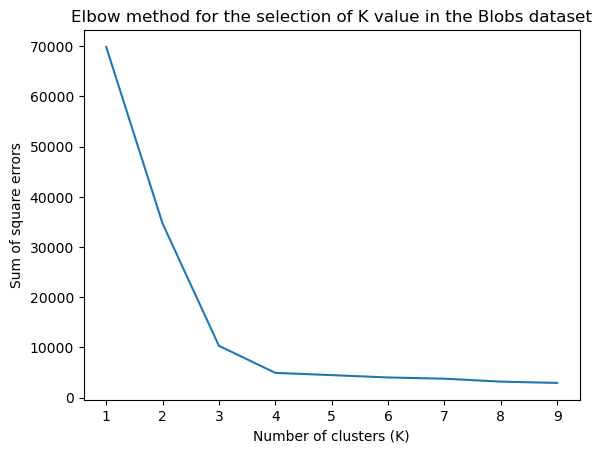

In [4]:
# Load the Bobs dataset as X and y variables
X, y = X_blobs, y_blobs

# Empty list to save SSEs
inertias = []

# Iterate through K values 1 to 10 and calculate SSE for each K value
for el in range(1,10):
    kmeans = cluster.KMeans(n_clusters=el,n_init='auto', random_state = 42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
# Generate elbow plot
plt.plot(range(1,10), inertias)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Sum of square errors")
plt.title("Elbow method for the selection of K value in the Blobs dataset")
plt.show()

We know that there are, in fact, 4 distinct groups in the dataset, so it makes sense for the value to be 4. Nevertheless, in principle, we could have chosen 3 as the optimal value. If we look at the points in our dataset, we will see that there are two groups that are closer to each other than the rest. In fact, if we choose 3 as the value of K (see the plot below), then we will see that those two closer groups will belong to the same cluster. That proximity is probably the reason why the decrease in the SSE value is clearly smaller from 3 clusters onward and improves slightly but not substantially with 4 clusters. Below, I implement the K-means algorithm with a K value of either 3 or 4. First, with K=3:

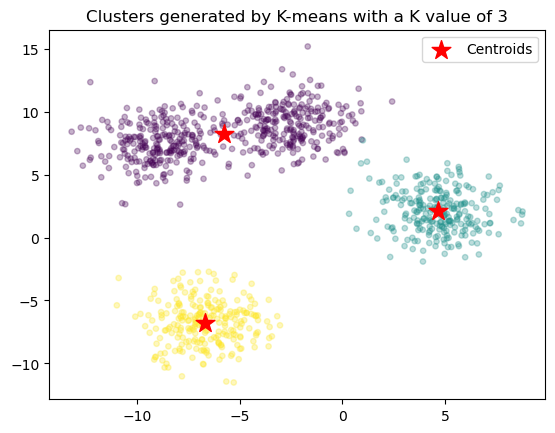

In [5]:
# K-means with a K value of 3 to demonstrate the effect of proximity in the clustering
kmeans = cluster.KMeans(n_clusters=3,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)

# Show the result
plt.scatter(X[:,0], X[:,1], s=15, c=result_kmeans, alpha=0.3)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.legend()
plt.title("Clusters generated by K-means with a K value of 3")
plt.show()

Regarding achieving a better selection of the number of clusters, we have different possibilities. One of them is to evaluate how well-separated the points assigned to the clusters are for each value of K. This is the essence of the silhouette coefficient method. It is a measure of the separation between clusters, as opposed to the SSE measure, which indicates how compact the clusters are.

There are other mechanisms to evaluate the quality of our choice of K, such as validating the cluster assignments if we have labels indicating the class each point belongs to, as in our case. From a less technical perspective, we might mention that sometimes domain knowledge about the dataset can be enough to choose the value of K.

Now, let's look at an example and implementation of the silhouette coefficient method, taken from the scikit-learn website and applied to our data:

For n_clusters = 2 The average silhouette_score is : 0.5079334010289336
For n_clusters = 3 The average silhouette_score is : 0.6814833917748337
For n_clusters = 4 The average silhouette_score is : 0.6678992533189723
For n_clusters = 5 The average silhouette_score is : 0.5818872250046244
For n_clusters = 6 The average silhouette_score is : 0.48971564658585864


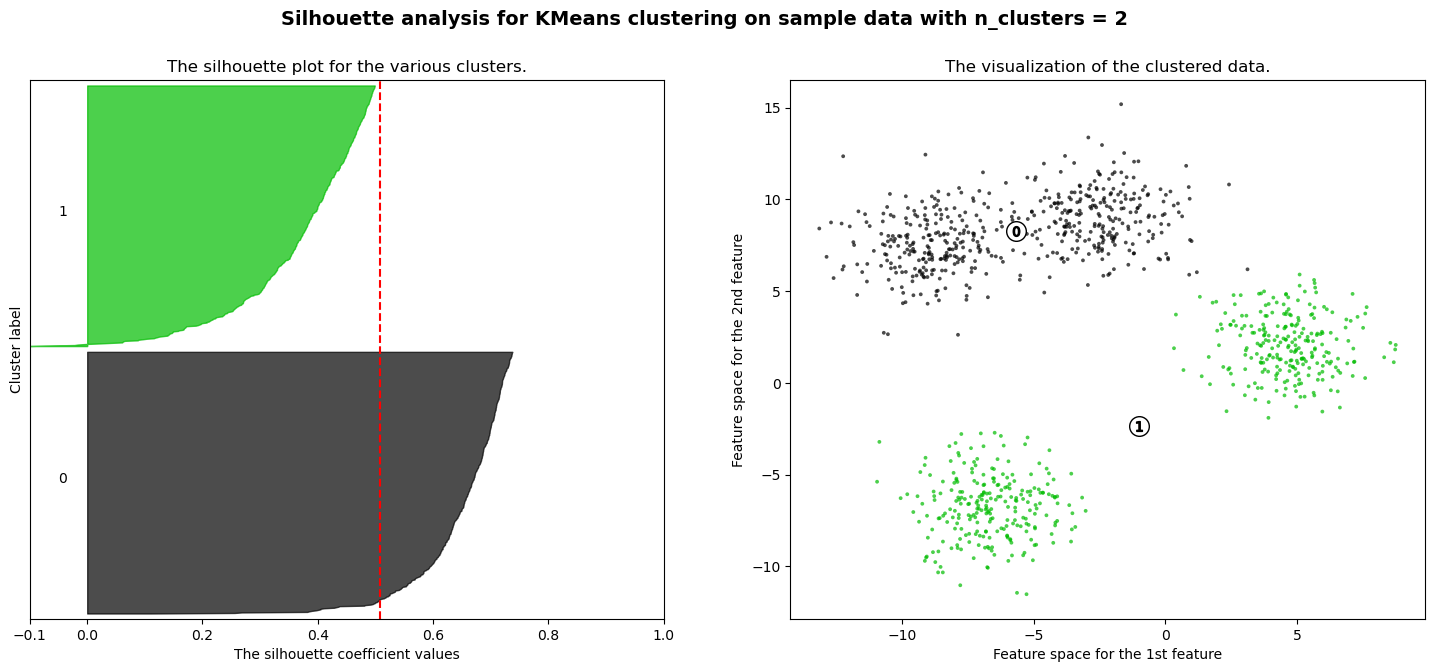

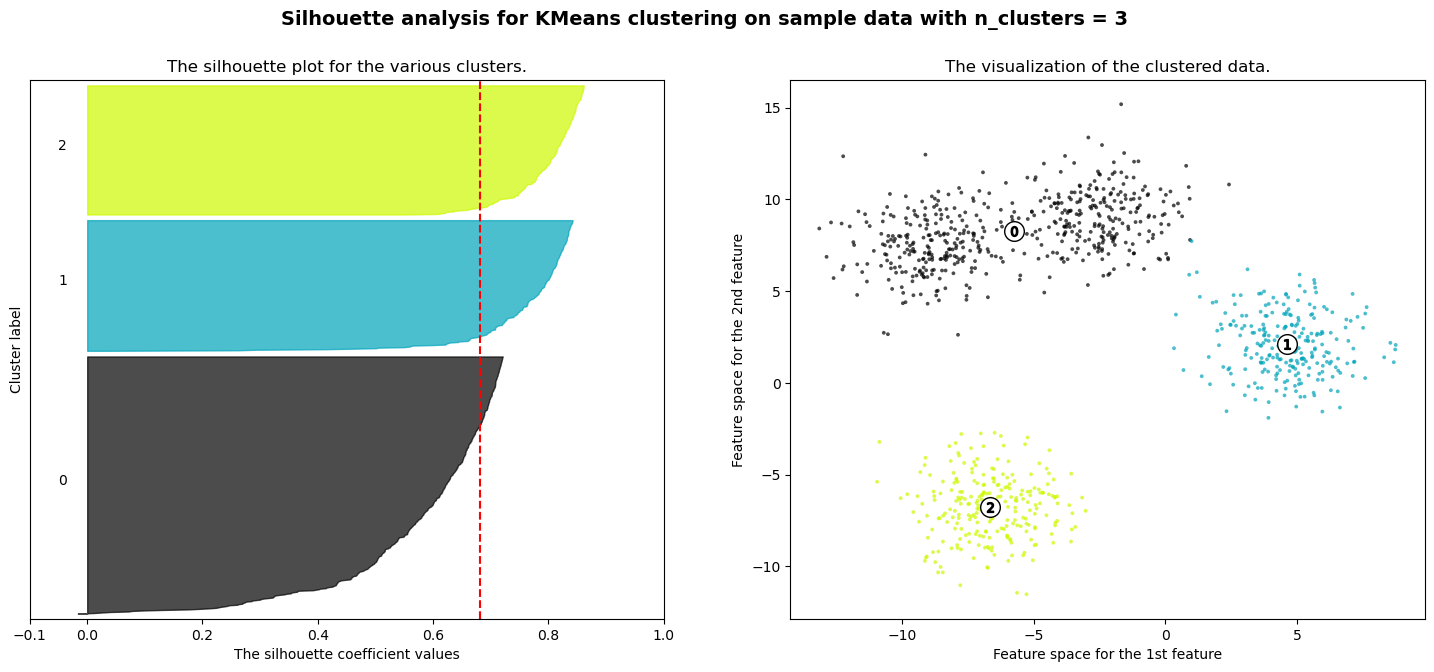

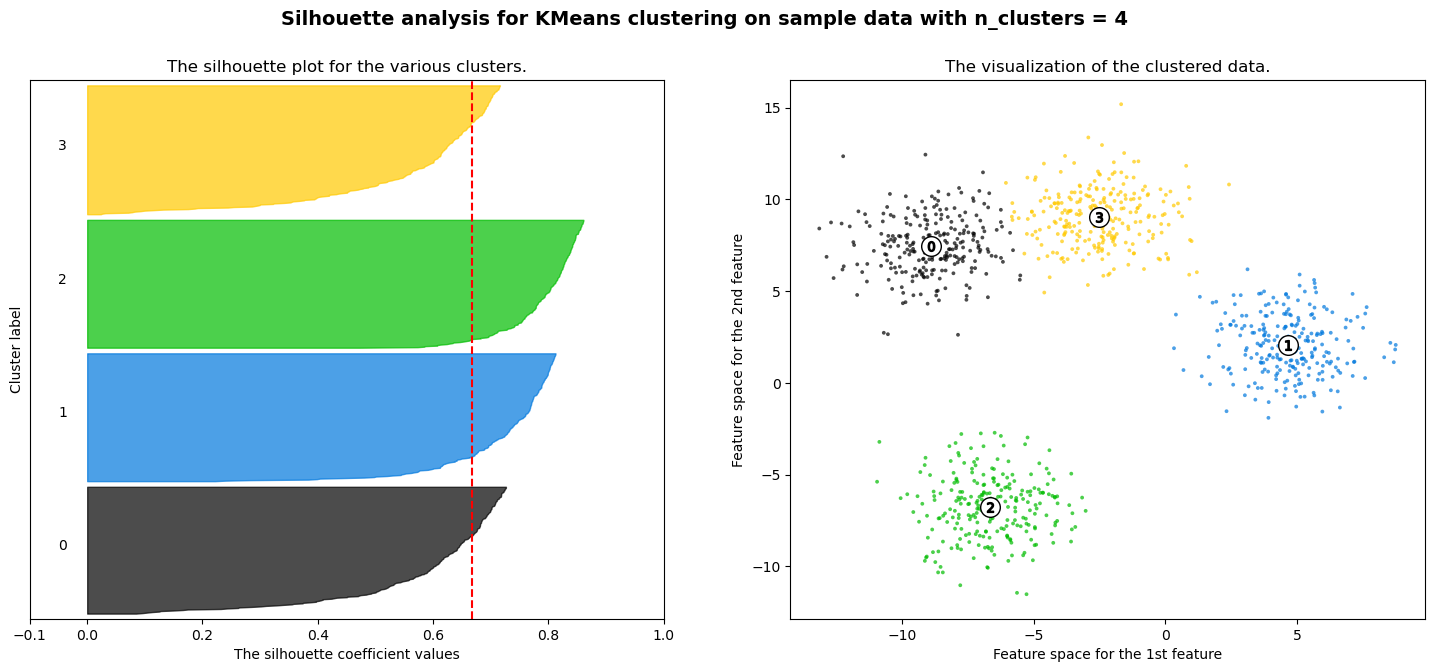

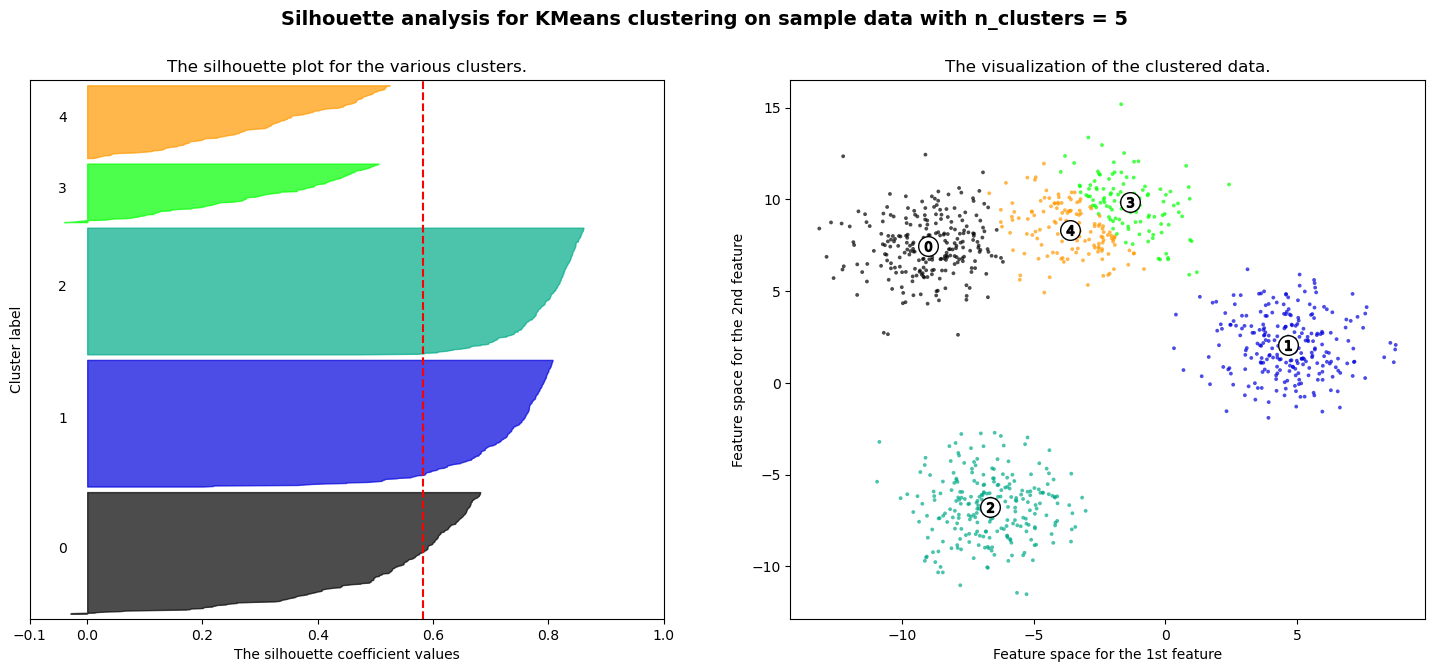

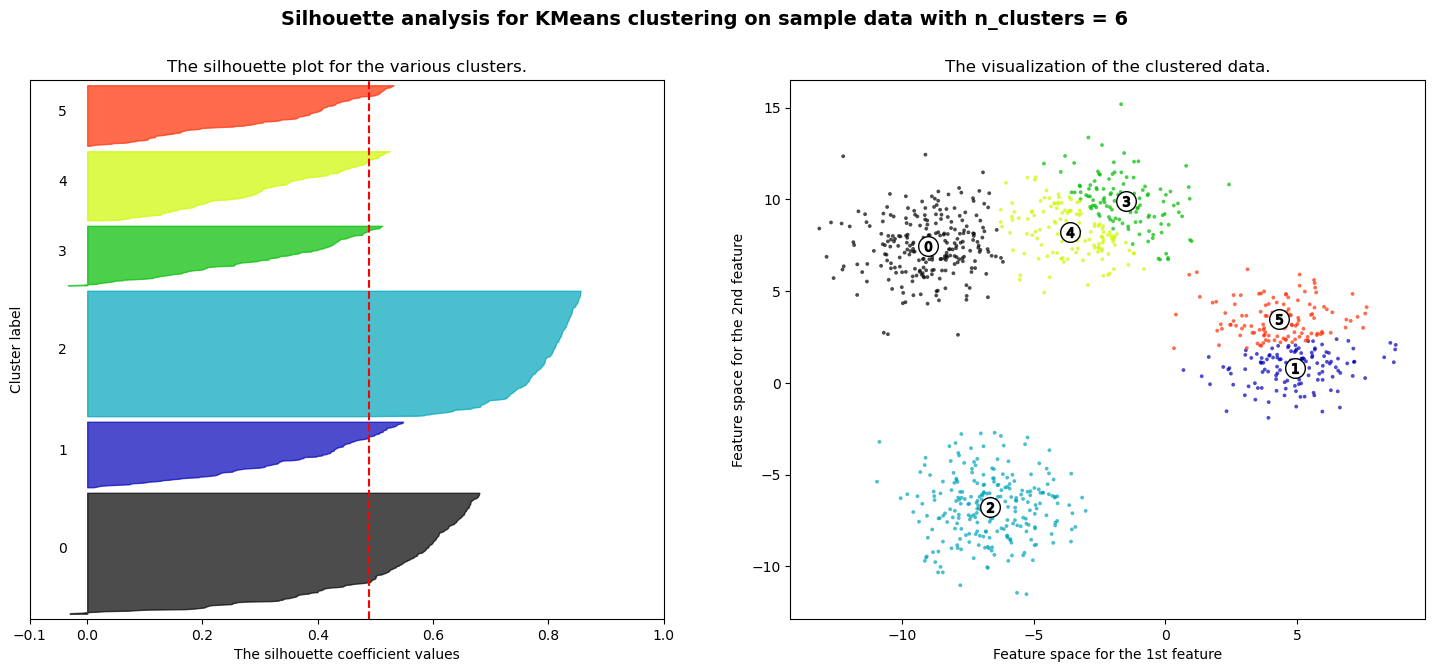

In [6]:
# Silhouette method implementation

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = cluster.KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()    

In this case, the metric associated with the method is the silhouette coefficient. The closer the value is to 1, the better separated our clusters are. We see that the highest values are for K=3 (silhouette coefficient of 0.68) and K=4 (0.66). As we can see, the value is actually slightly better for 3 clusters than for 4.

I believe this is because, with k=3, the separation between the "macro-cluster" formed in the upper left corner of the graph and the other two smaller clusters is better than when K=4. In the latter case, the separation between the two clusters in the upper left corner becomes "poorer."

Here the implementation of the algorithm with K=4:

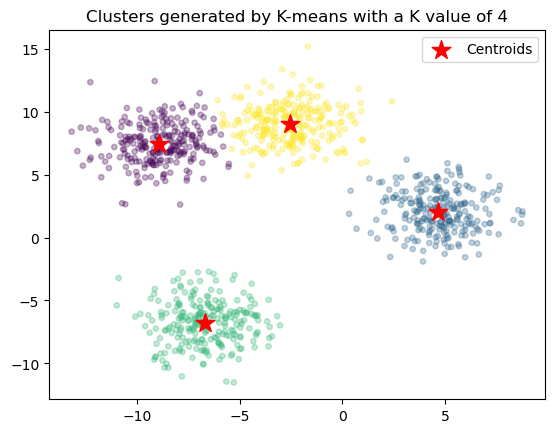

In [7]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=4,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)
    
# Mostrar la asignación de puntos del dataset a los clústers
plt.scatter(X[:,0], X[:,1], s=15, c=result_kmeans, alpha=0.3)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.legend()
plt.title("Clusters generated by K-means with a K value of 4")
plt.show()

As expected, we have 4 clusters similar to the "real" groups, and the centroids appear positioned as anticipated. Before continuing with the analysis, let's revisit those real groups because they will help us understand what we can expect from an algorithm like K-means:

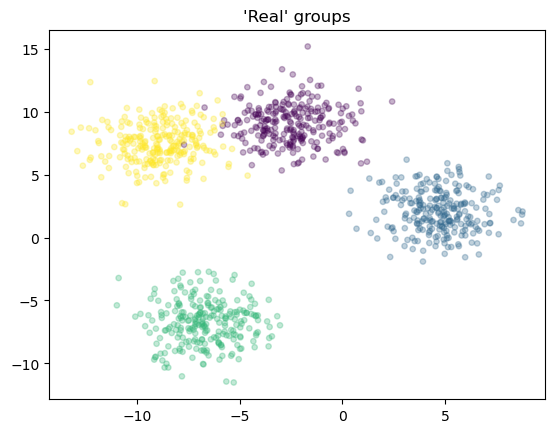

In [8]:
# Show the real groups for the Blobs dataset
plt.scatter(X[:,0], X[:,1], s=15, c=y, alpha=0.3)
plt.title("'Real' groups")
plt.show()

We can begin the analysis by stating that the mechanism of K-means involves trying to minimize the distance (whichever distance metric we choose) between the points in the dataset and the centroids of the clusters. From this, a few considerations arise.

First, K-means works best with groups that have a relatively circular or spherical shape. This is easy to observe in a dataset like Blobs. Here, we have 4 groups where a center is easily noticeable, and the shape is relatively circular. Under these conditions, K-means performs well and can assign points to clusters in a way that closely matches reality.

In fact, we can calculate how well our algorithm has performed:

In [9]:
# 'Real' clusters have slightly different names compared to the K-means output clusteres, so I start by renaming them:

result_kmeans_rename = np.where(result_kmeans == 0, 3, np.where(result_kmeans == 3, 0, result_kmeans))

# Calculate the percentage of coincidence between the two:
coincidence = np.mean(y == result_kmeans_rename) * 100
coincidence

99.2

We see that our K-means algorithm is correct 99.2% of the time. This case was particularly easy for this algorithm, but even so, we must note one more thing.

In cases where points that we know belong to one group are near or inside another group (there are some in this dataset), the assignment to a cluster will be incorrect. Additionally, wherever there are points on the "boundary" between two groups, it is more likely for the algorithm to make errors in the assignment.

## 1.1.2. K-Means with the Moons dataset

Here the elbow plot for the Moons dataset:

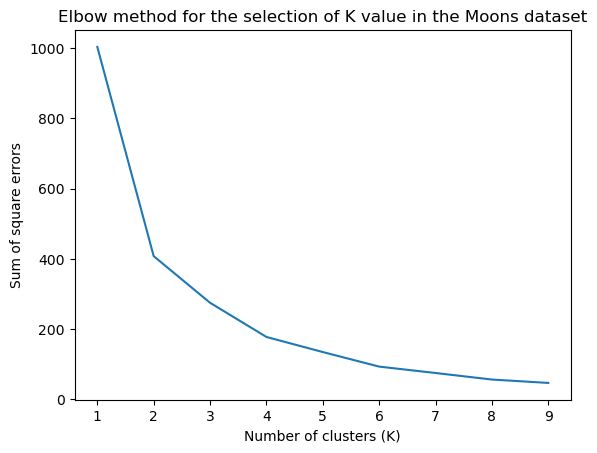

In [10]:
# Load the Moons dataset as X and y variables
X, y = X_moons, y_moons

# Empty list to save SSEs
inertias = []

# Iterate through K values 1 to 10 and calculate SSE for each K value
for el in range(1,10):
    kmeans = cluster.KMeans(n_clusters=el,n_init='auto', random_state = 42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
# Generate elbow plot
plt.plot(range(1,10), inertias)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Sum of square errors")
plt.title("Elbow method for the selection of K value in the Moons dataset")
plt.show()

We notice that in this dataset, the decrease in SSE is much less "abrupt" compared to the case of blobs. Therefore, choosing the number of clusters seems more difficult (we'll see below that this is indeed not the best dataset for K-means, given the "shape" of the groups). Two small elbows can be observed, one at K=2 and another at K=4. Below, we will visualize the result with both values.

In this case, I believe the best way to choose the value of K is by looking at the plot of the dataset points. Visually, it seems obvious that there are two groups, so that would be the ideal value to work with. I think using the silhouette coefficient criterion in this case would not make much sense because we know that K-means works by "placing" centroids and moving them based on the distances of points to those centroids, but it will not be able to generate well-separated groups with high silhouette coefficient values. We can see this with the code:

For n_clusters = 2 The average silhouette_score is : 0.48633947635957203
For n_clusters = 3 The average silhouette_score is : 0.4229980895895807
For n_clusters = 4 The average silhouette_score is : 0.4573975750690784
For n_clusters = 5 The average silhouette_score is : 0.4831806526436417
For n_clusters = 6 The average silhouette_score is : 0.5097793680426884


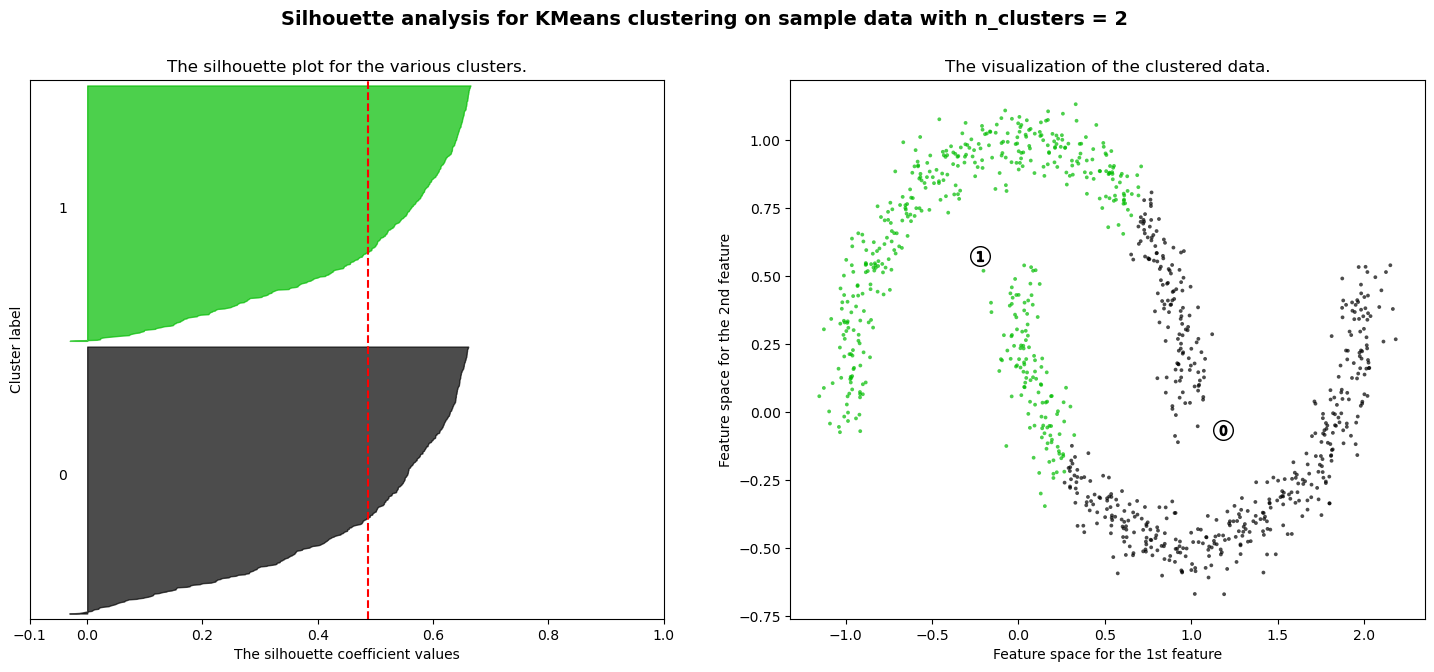

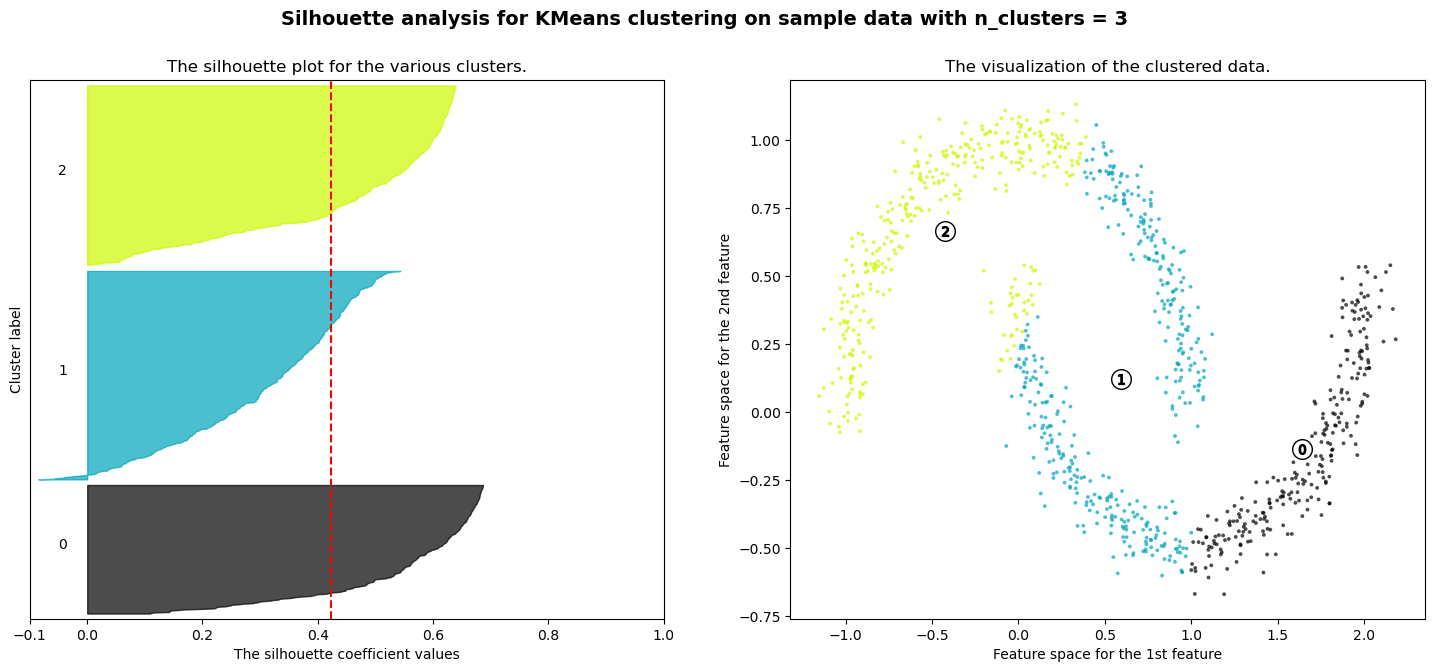

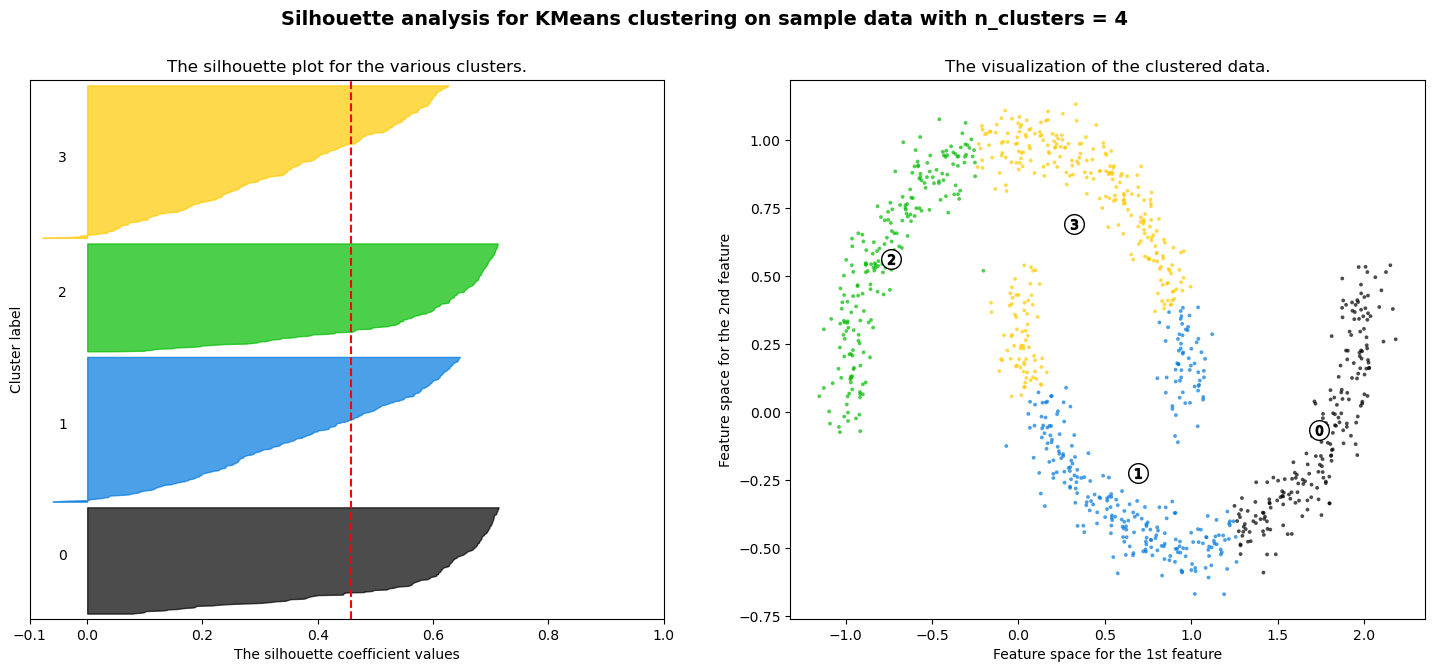

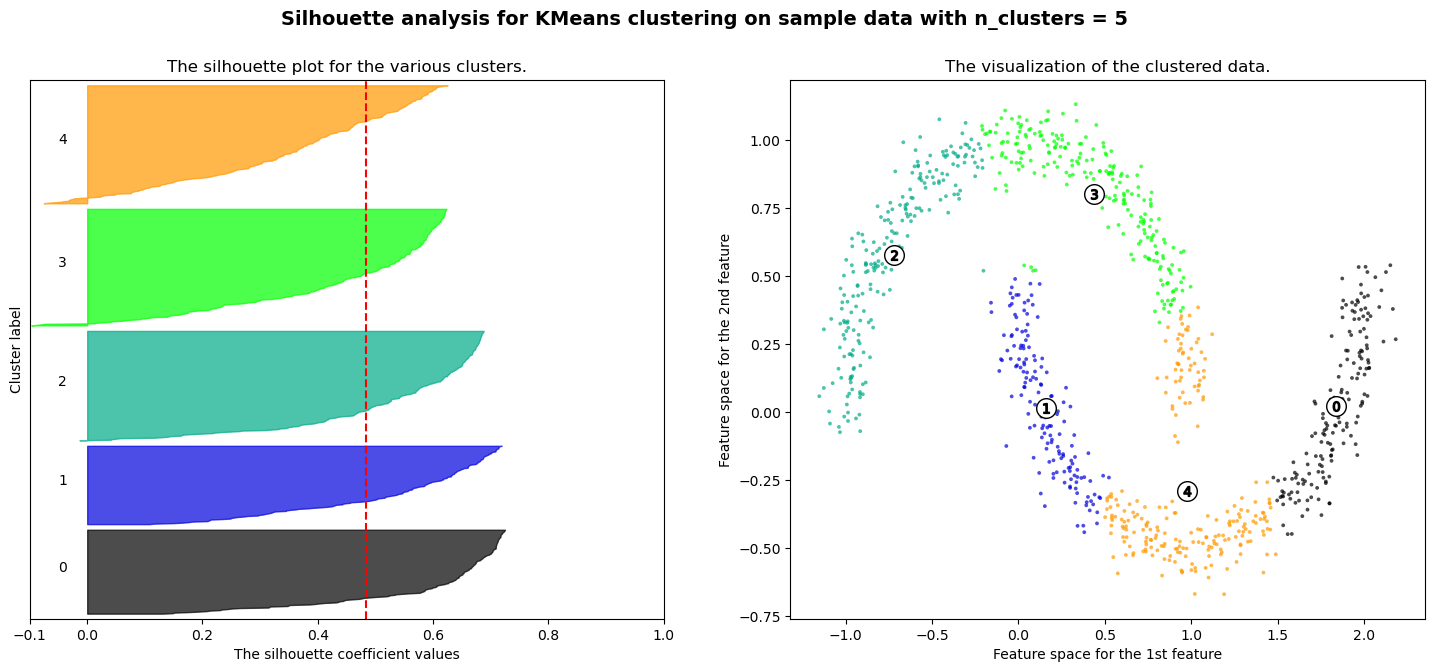

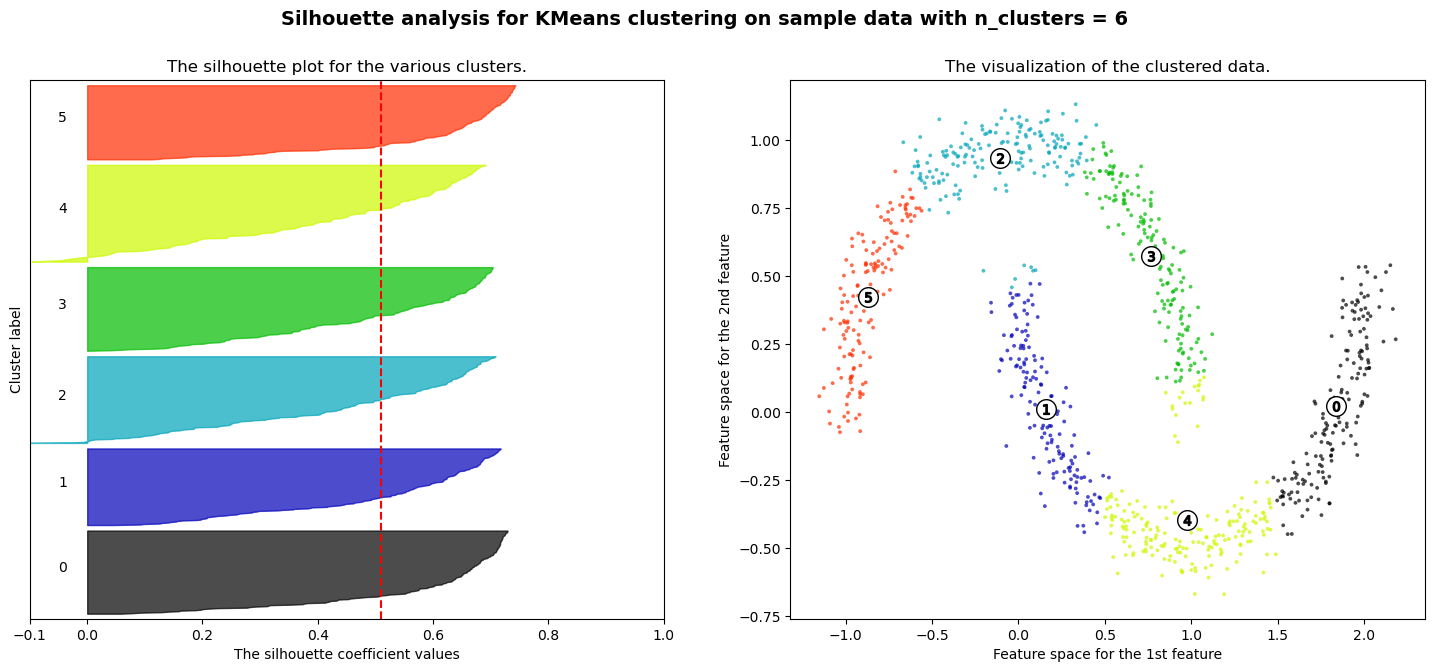

In [11]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = cluster.KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()    

We see that the average silhouette coefficient is lower in this case compared to the blobs dataset, which makes sense considering that, in the blobs case, K-means was assigning points to clusters that were similar to the real groups. However, in this case, K-means generates clusters that "cut" through the real groups, which results in a worse silhouette coefficient. This happens because K-means is trying to minimize the distance between points and centroids, but the actual group structure in this dataset does not align well with spherical or circular clusters, leading to less accurate assignments and a lower silhouette score.

This is the implementation with K=2:

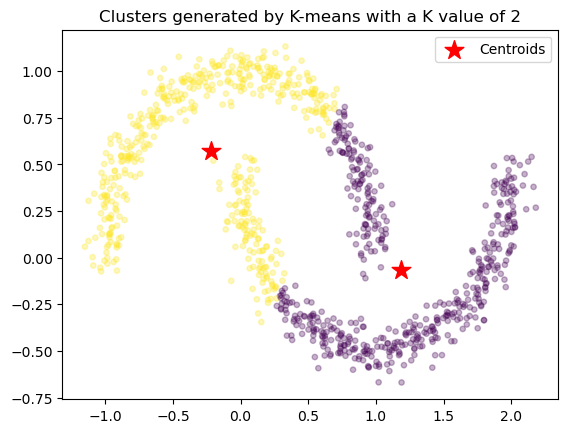

In [12]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=2,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)
    
# Mostrar la asignación de puntos del dataset a los clústers
plt.scatter(X[:,0], X[:,1], s=15, c=result_kmeans, alpha=0.3)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.legend()
plt.title("Clusters generated by K-means with a K value of 2")
plt.show()

Now, let's show the result for the other "relevant" value we extracted from the SSE plot, which is k=4:

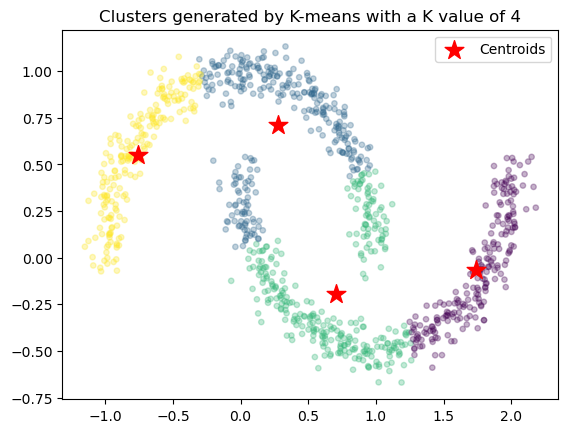

In [13]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=4,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)
    
# Mostrar la asignación de puntos del dataset a los clústers
plt.scatter(X[:,0], X[:,1], s=15, c=result_kmeans, alpha=0.3)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.legend()
plt.title("Clusters generated by K-means with a K value of 4")
plt.show()

As we mentioned, this dataset is not ideal for clustering using an algorithm like K-means. The reason is that the shape of the groups is not the most suitable because it is not circular or spherical. There isn't a center around which the points of each group cluster, so the K-means strategy fails to generate the clusters effectively.

If we look at the position of the centroids (let's take the plot with k=2 for simplicity), we see that the centroids are not in a region around which there is a point structure like the one we had in the blobs dataset. The two clusters are generated, as expected, based on the distances of the points to those centroids, but they don't resemble the real groups. In later exercises, we will see how using other algorithms that follow different strategies, we can generate appropriate clusters.

Before moving on, let's make another observation. As we can see, the centroids in the case of k=4 are much closer to the clouds of points. A bit later, we will leverage this to "artificially" generate clusters in which the assignment of points is almost identical to that of the real groups.

To assign a metric to the quality of our clustering using K-means, let's see what proportion of the points from the real groups we have been able to group correctly. First, let's look at what these "real" groups are:

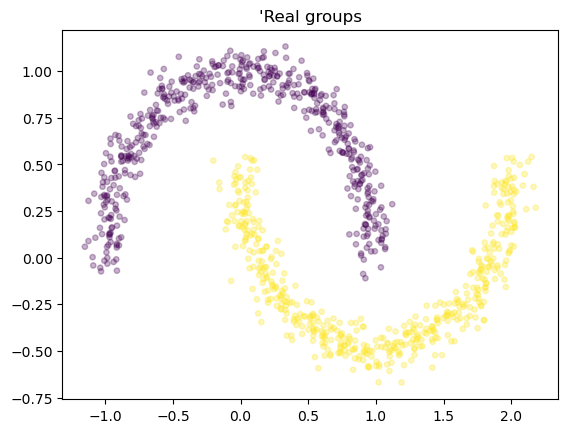

In [14]:
# Show the real groups in the moons dataset
plt.scatter(X[:,0], X[:,1], s=15, c=y, alpha=0.3)
plt.title("'Real groups")
plt.show()

Now, let's see what proportion of the points we have grouped correctly:

In [15]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=2,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)

# 'Real' clusters have slightly different names compared to the K-means output clusteres, so I start by renaming them:

result_kmeans_rename = np.where(result_kmeans == 0, 1, np.where(result_kmeans == 1, 0, result_kmeans))

# Calculate the percentage of coincidence between the two:
coincidence = np.mean(y == result_kmeans_rename) * 100
coincidence

74.4

We see that the accuracy percentage drops to 74.4%. This is not equivalent to randomly assigning points to clusters, but it is far from the 99.2% accuracy we saw with the blobs dataset. The underlying idea here is that the shape of the groups (the distribution of the points) is what determines how effective an algorithm will be in clustering those points.

In fact, by manipulating the position of the points, we should be able to make K-means produce a result that is similar to a random assignment. This demonstrates that K-means is sensitive to the structure of the data and that its performance depends heavily on how well the data clusters match the algorithm's assumptions of spherical or circular clusters.

One could think about possibilities that might help K-means to perform better with this dataset. An obvious possibility would be to change the algorithm. But, if we want to delve deeper into the use of K-means, there are several ways we can make the clustering process more effective:

1. Add more dimensions: By simply adding extra dimensions that help separate the points, we might move closer to a more efficient clustering with K-means. The idea is to create more distance between the points of the two groups so that K-means can more easily distinguish between them.

2. Change the existing dimensions: This dataset might not be the best fit for this, but if we are able to perform dimensionality reduction (for example, in a dataset with more dimensions), we could obtain dimensions that better reflect the differences between the groups. This would make it easier for K-means to assign points to the correct clusters.

3. Combine K-means with other strategies: In this case, we can easily distinguish the two groups in the dataset. One way to "help" K-means do the same could be to ask it to generate a larger number of clusters (ensuring that it does not mix points from the two real groups in any one cluster), and then manually combine those clusters afterward. We can see an example of this, as well as the result it has on the clustering:

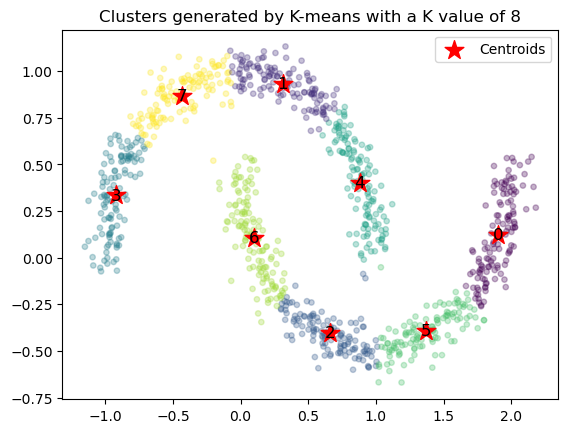

In [16]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=8,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)
    
# Show the clustering result
plt.scatter(X[:, 0], X[:, 1], s=15, c=result_kmeans, alpha=0.3)

# Set a label to each centroid to later bind them together
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
for i, c in enumerate(centroids):
    plt.text(c[0], c[1], str(i), fontsize=12, color='black', ha='center', va='center')

plt.legend()
plt.title("Clusters generated by K-means with a K value of 8")
plt.show()

We can see that with 8 clusters, there are very few points that fall into the same cluster but belong to different real groups. If we now manually group these clusters (using the labels), we could approach the real groups more closely.

By increasing the number of clusters, we make it less likely that K-means will mix points from the different real groups. Afterward, by merging or reassociating these clusters manually, we can achieve a much closer match to the real groupings:

In [17]:
# Rename labels:
result_kmeans = np.where(result_kmeans == 3, 9, result_kmeans)
result_kmeans = np.where(result_kmeans == 7, 9, result_kmeans)
result_kmeans = np.where(result_kmeans == 1, 9, result_kmeans)
result_kmeans = np.where(result_kmeans == 4, 9, result_kmeans)

result_kmeans = np.where(result_kmeans != 9, 10, result_kmeans)

result_kmeans_rename = np.where(result_kmeans == 9, 0, np.where(result_kmeans == 10, 1, result_kmeans))

In [18]:
# And calculate the percentage of coincidences between the two:
coincidence = np.mean(y == result_kmeans_rename) * 100
coincidence

99.6

We see that we get much closer (99.6% accuracy) to the optimal result:

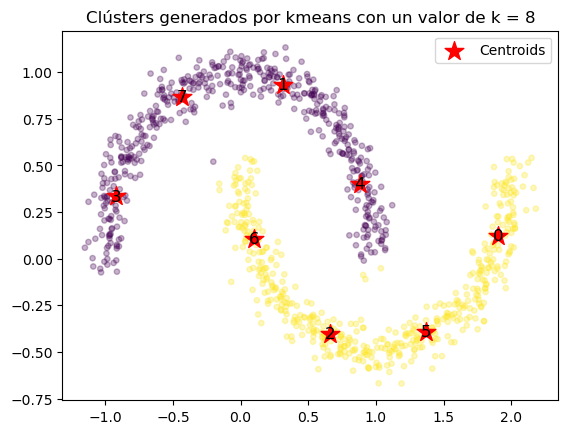

In [19]:
plt.scatter(X[:, 0], X[:, 1], s=15, c=result_kmeans_rename, alpha=0.3)

# Set a label to each centroid to later bind them together
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
for i, c in enumerate(centroids):
    plt.text(c[0], c[1], str(i), fontsize=12, color='black', ha='center', va='center')

plt.legend()
plt.title("Clústers generados por kmeans con un valor de k = 8")
plt.show()

Obviously, this is a somewhat "artificial" way of achieving the result, but we are still using K-means to get there.

## 1.1.3. K-Means with the Circles dataset

Here the elbow plot for the Circles dataset:

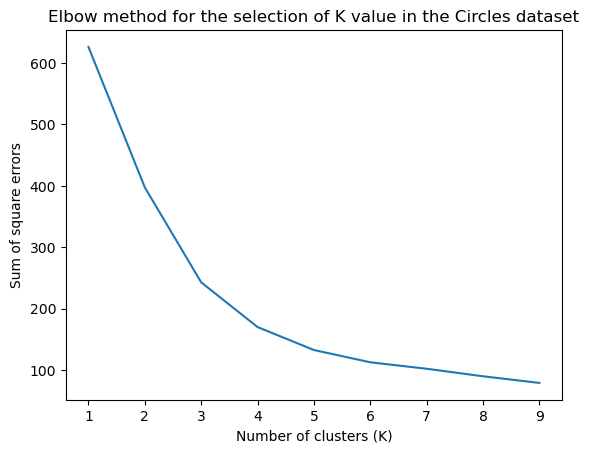

In [20]:
# Load the Circles dataset as X and y variables
X, y = X_circles, y_circles

# Empty list to save SSEs
inertias = []

# Iterate through K values 1 to 10 and calculate SSE for each K value
for el in range(1,10):
    kmeans = cluster.KMeans(n_clusters=el,n_init='auto', random_state = 42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
# Generate elbow plot
plt.plot(range(1,10), inertias)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Sum of square errors")
plt.title("Elbow method for the selection of K value in the Circles dataset")
plt.show()

We can see that, just like with the moons dataset, in the case of the circles dataset, it is not easy to determine the optimal number of clusters using the elbow method. The decrease in SSE is very gradual, and there is no particularly visible elbow. Perhaps the best values could be 3 or 4.

At this point, we know that K-means is not an algorithm that will work well with this type of dataset. While it is true that the points are roughly placed on a circle, the hypothetical center of both circles is the same. Given that K-means works by using centroids and distances to the centroid, it is easy to understand that it will struggle to find groups that resemble the real ones.

Knowing how the algorithm works and understanding the dataset, I believe that using the silhouette coefficient won't provide us with much useful information either, but let's take a look at it:

For n_clusters = 2 The average silhouette_score is : 0.3533643867381888
For n_clusters = 3 The average silhouette_score is : 0.38920916117671583
For n_clusters = 4 The average silhouette_score is : 0.3818332162225793
For n_clusters = 5 The average silhouette_score is : 0.3585359142222443
For n_clusters = 6 The average silhouette_score is : 0.36158088949523365


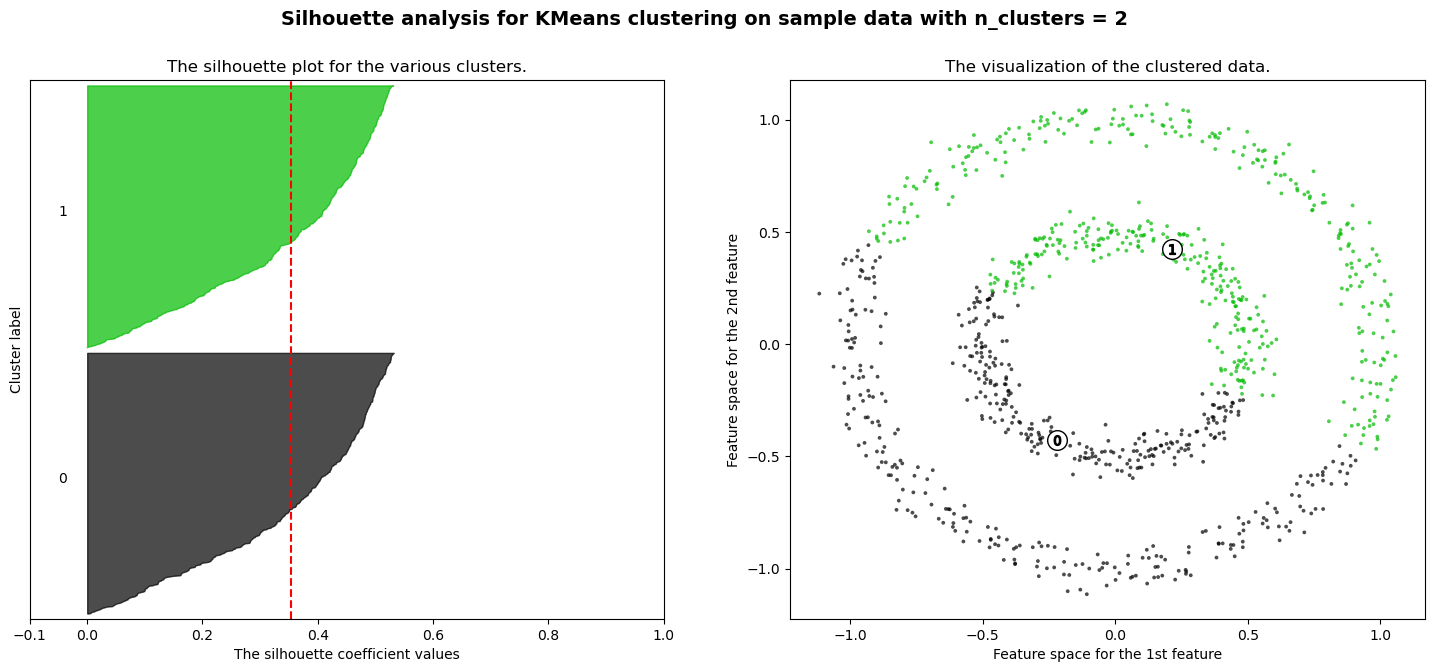

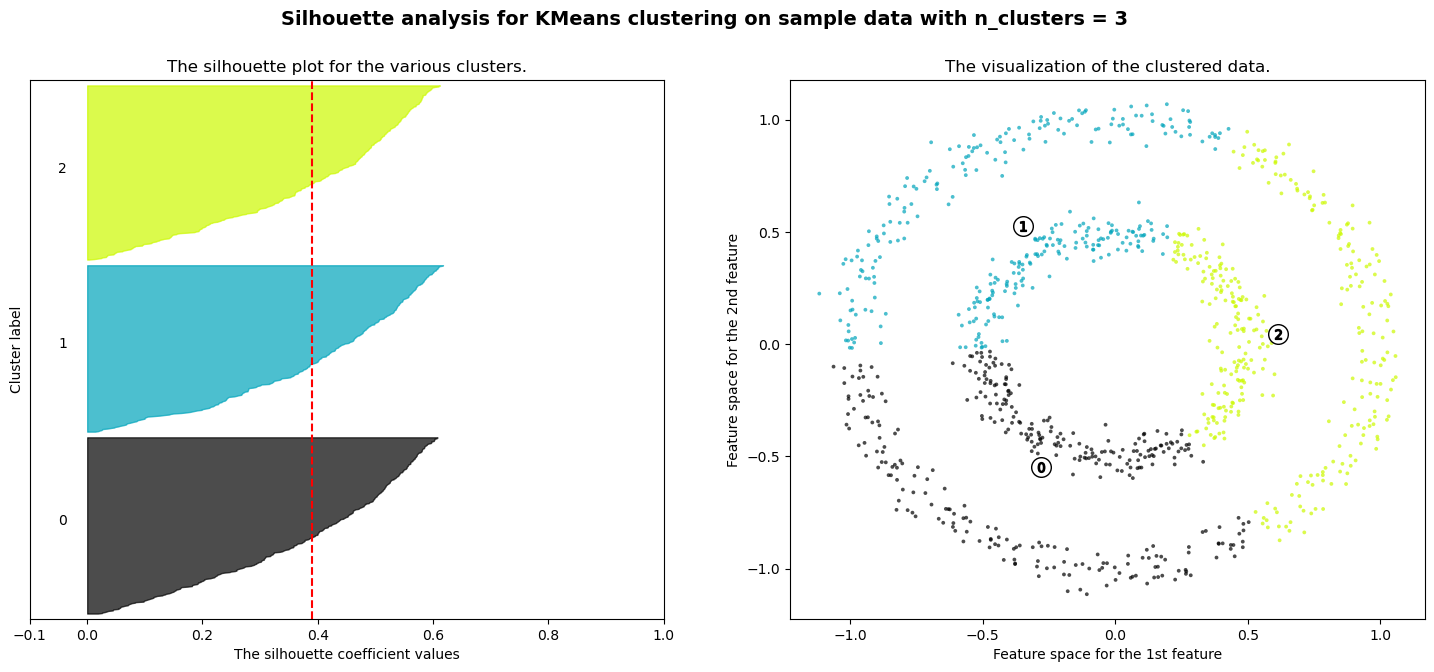

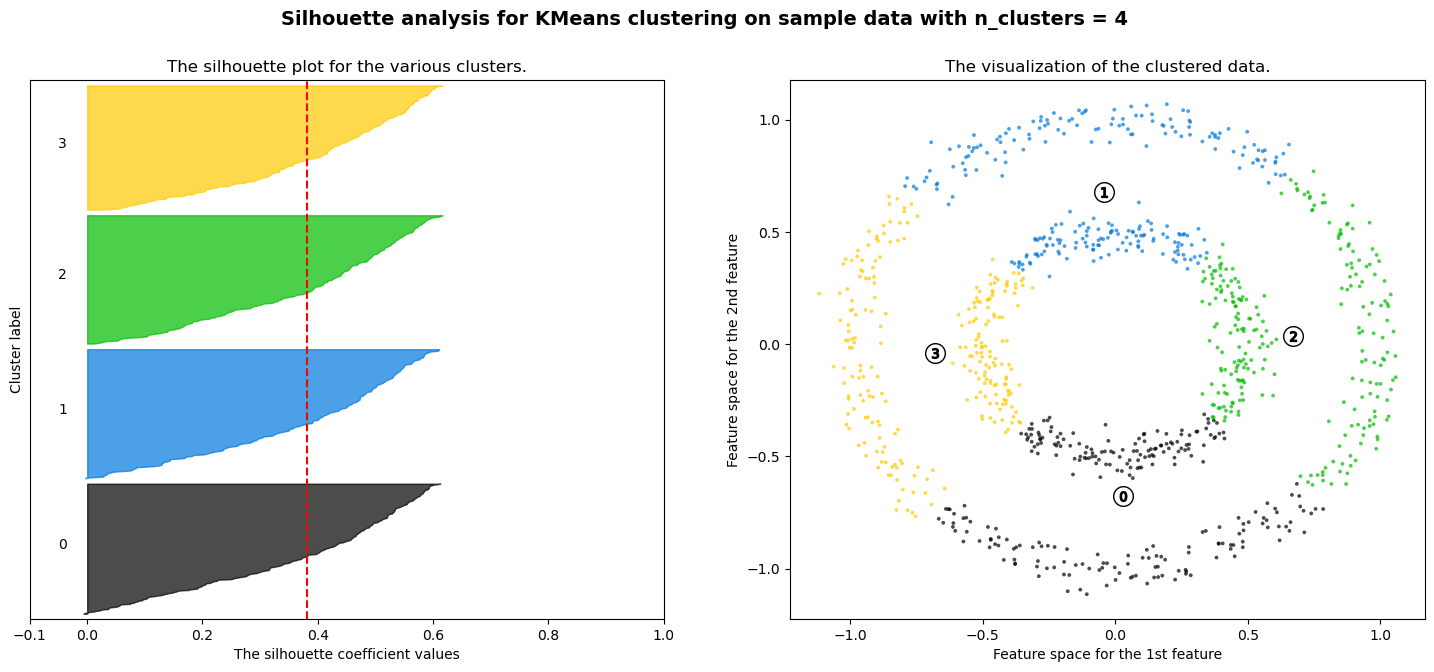

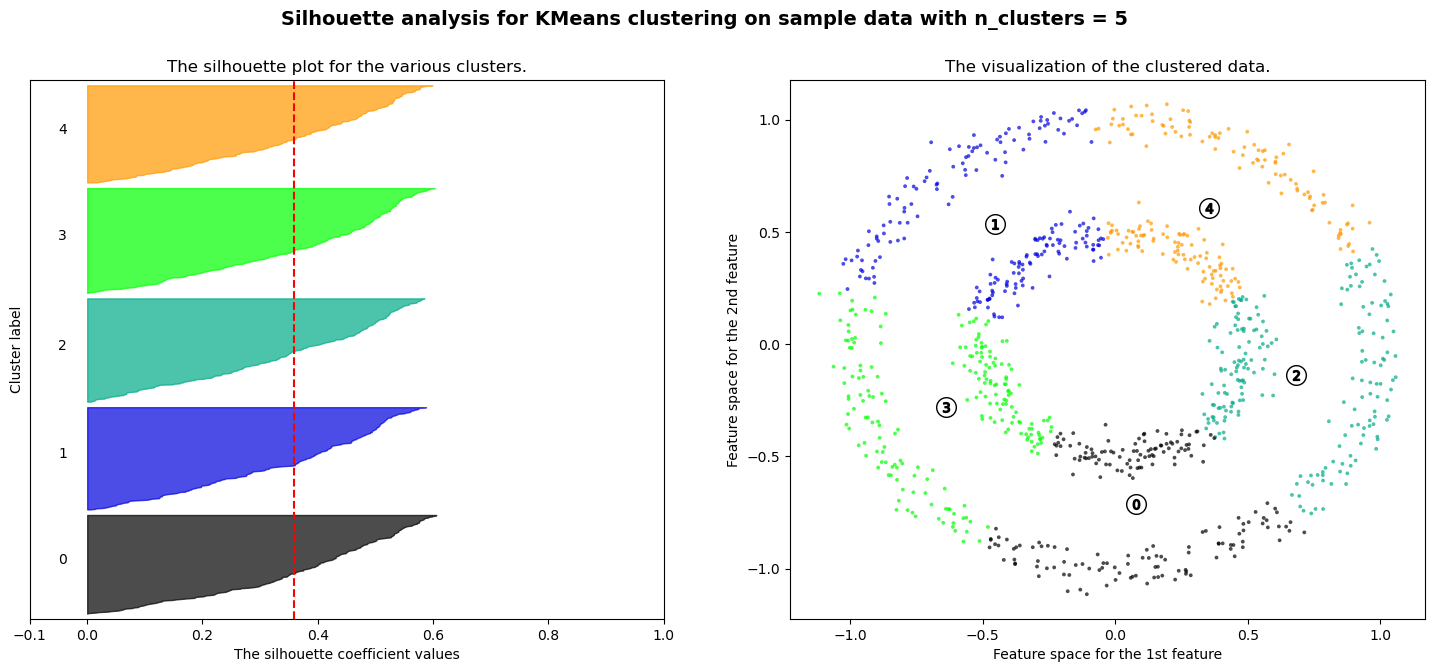

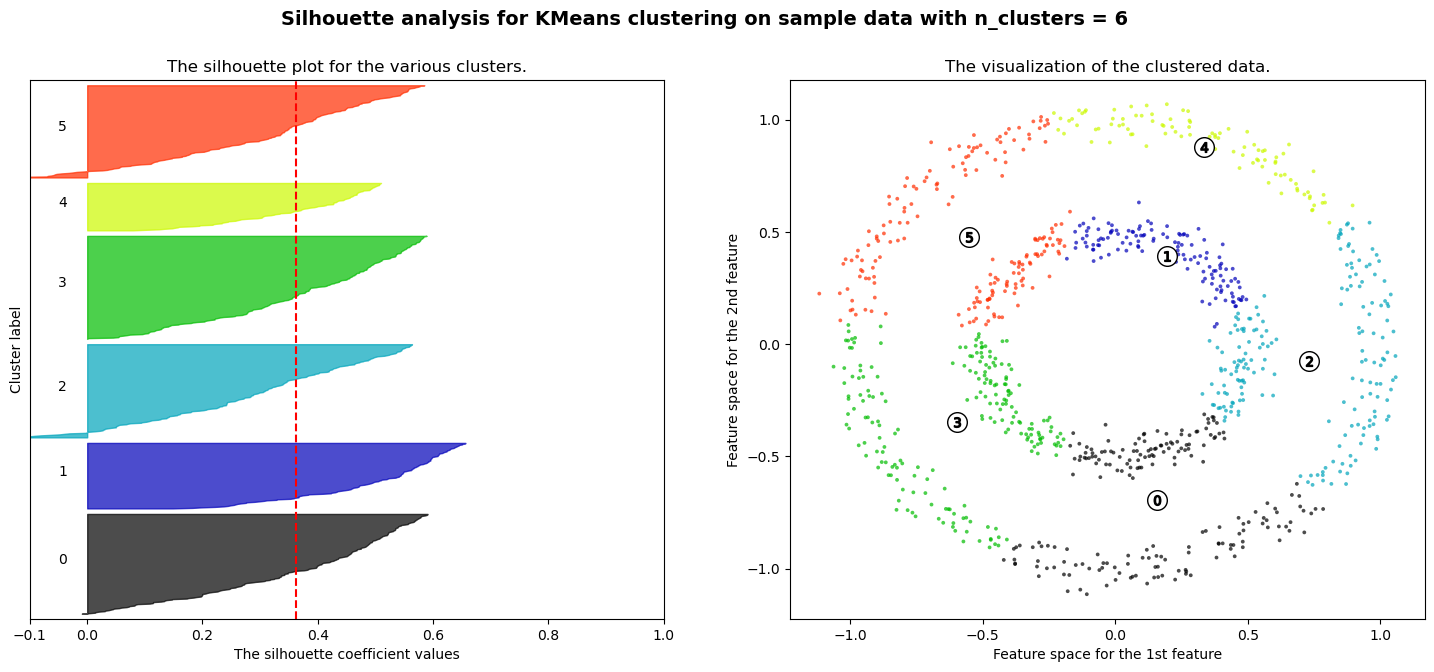

In [21]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = cluster.KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()    

Indeed, the result is even worse than with the moons dataset. This is because it is not possible to find two centroids around which to generate clusters with well-isolated points. The silhouette coefficient values are much lower than those seen with blobs, which is the ideal dataset (among the three we explore in this part of the practice) for K-means.

At this point, I believe, just like with moons, the best approach is to visually determine the optimal number of clusters, which in this case is 2

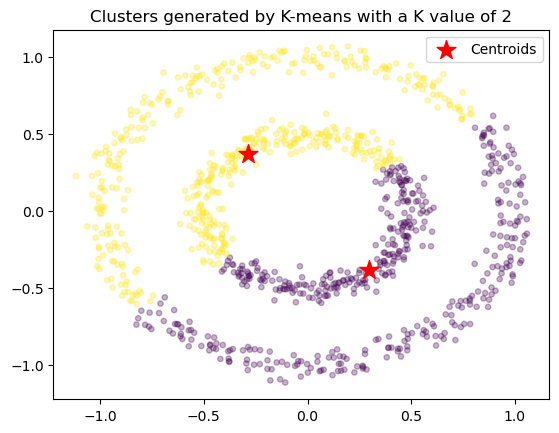

In [22]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=2,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)
    
# Mostrar la asignación de puntos del dataset a los clústers
plt.scatter(X[:,0], X[:,1], s=15, c=result_kmeans, alpha=0.3)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.legend()
plt.title("Clusters generated by K-means with a K value of 2")
plt.show()

We see that we have two centroids, but both are within one of the two real groups. The clusters split the points into two groups without seemingly improving on a random separation. In fact, we can calculate the efficiency of the algorithm:

In [23]:
coincidence = np.mean(y == result_kmeans) * 100
coincidence

50.3

As expected, the result (50.3% accuracy) is very close to what we would get by randomly assigning the values. This dataset helps us understand the importance of choosing the right algorithm, taking into account the method each algorithm follows. As we have mentioned, the centroids established by the algorithm cannot help us group the points because there is nothing resembling a center of the distributions, populated by points, in the real groups. Additionally, to minimize the distances from points to a centroid while keeping the points in the real groups, we would need to make the centroids coincide, which is something K-means cannot do.

Of course, we could follow a strategy similar to the previous example (i.e., generate more clusters and manually group them), but we have access to much better algorithms, as we will see next.

## 1.2. DBSCAN

As we have seen in the previous section, K-means is an algorithm that works better with points arranged in a round-shaped manner. The main disadvantage of the algorithm is the need for a user-defined value for K. One alternative algorithm that does not require the user to pre-define the number of clusters is *DBSCAN* (Density-Based Spatial Clustering of Applications with Noise). In DBSCAN, it is the *density* of data points in specific regions of the feature space what determines the nuber of clusters ([here a simple explanation of how it works](https://www.youtube.com/watch?v=RDZUdRSDOok)). Here, size and shape are not particularly relevant, but the parameters the user needs to select deal with density-related metrics. Therefore, datasets with very different clusters in terms of density of data points will not be easily handled by DBSCAN.

In DBSCAN, we can adjust the parameters eps and min_samples to improve the assignment of points to clusters. The first parameter, eps, refers to the distance threshold between two points below which the algorithm considers them neighbors. The second parameter, min_samples, defines the minimum number of points within the neighborhood of a point in the dataset for it to be considered a "core" point.

Thus, if we increase the value of eps, more points will be considered neighbors, potentially leading to larger clusters, and vice versa. On the other hand, increasing the value of min_samples makes the algorithm more restrictive regarding the density of points required to classify a point as a core.Td, the number of clusters depends on the eps and min_samples parameters and the distribution of points in the dataset. Therefore, to adjust the number of clusters and the assignment of points to those clusters, we will modify the eps and min_samples parameters. Let's start by using the default parameters (eps = 0.5 and min_samples = 5):


## 1.2.1. DBSCAN with Blobs dataset

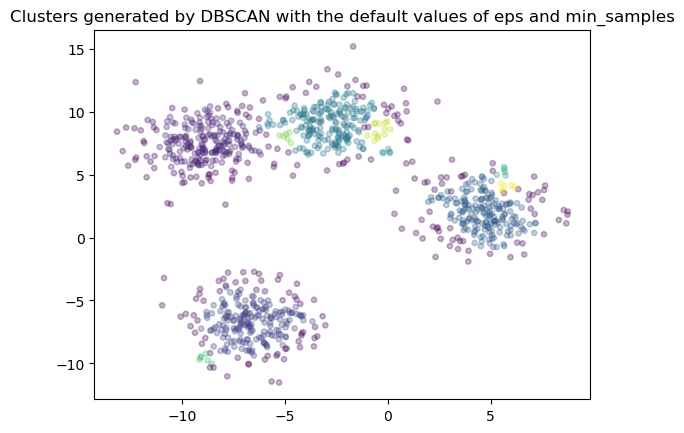

In [24]:
# Load the Blobs dataset as X and y variables
X, y = X_blobs, y_blobs

# DBSCAN with default parameters
dbscan = cluster.DBSCAN()

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with the default values of eps and min_samples")
plt.show()

We observe that with the default values, some interesting things happen. First, the assignment of points does not closely resemble the actual groups. Additionally, since DBSCAN is a density-based algorithm, we notice that it is very sensitive to outliers. There are many points around the denser areas that the algorithm does not group into the same cluster as the points in those dense regions. In fact, we can see that there are many points that the algorithm has not assigned to any cluster:

In [25]:
clusters, counts = np.unique(result_dbscan, return_counts=True)

# Create a dictionary with the data:
cluster_counts = dict(zip(clusters, counts))

print("Data points per cluster:", cluster_counts)

Data points per cluster: {-1: 230, 0: 185, 1: 181, 2: 180, 3: 183, 4: 5, 5: 5, 6: 6, 7: 6, 8: 13, 9: 6}


The points that the algorithm has not been able to assign to a cluster are labeled as -1. We see that with these parameters, there are 230 points falling into the unassigned category, which is almost a quarter of the total points. Therefore, it seems we could try to improve the result by increasing eps and/or decreasing min_samples. Let's see the outcome after applying these changes:

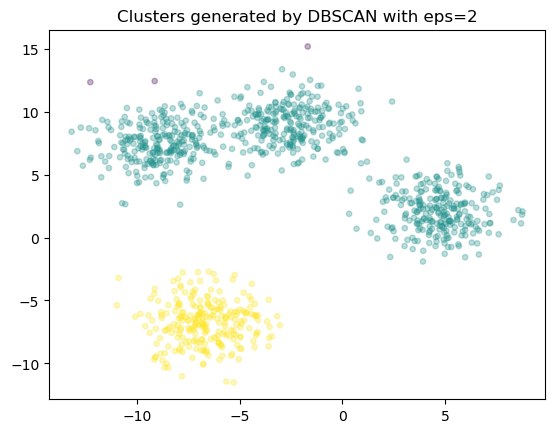

In [26]:
# DBSCAN increasing eps to 2
dbscan = cluster.DBSCAN(eps=2)

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with eps=2")
plt.show()

We see that the number of points considered noise (i.e., labeled as -1) decreases significantly, but in exchange, we lose clusters. Let's see what happens with an intermediate value of eps:

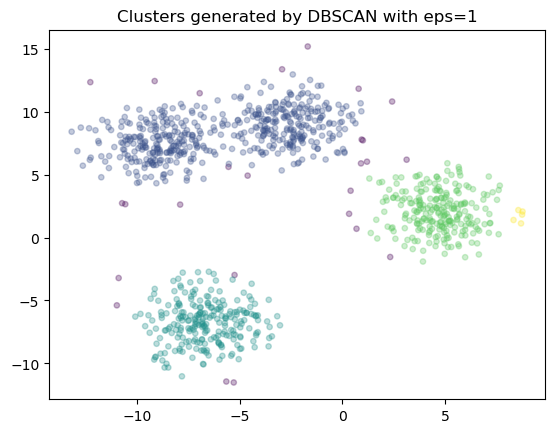

In [27]:
# DBSCAN increasing eps to 1
dbscan = cluster.DBSCAN(eps=1)

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with eps=1")
plt.show()

We have recovered a cluster without significantly increasing the number of points considered noise. Let's see how many we have now:

In [28]:
clusters, counts = np.unique(result_dbscan, return_counts=True)

# Create a dictionary with the data:
cluster_counts = dict(zip(clusters, counts))

print("Data points per cluster:", cluster_counts)

Data points per cluster: {-1: 26, 0: 484, 1: 245, 2: 240, 3: 5}


Indeed, we now have only 26 points considered noise. At the moment, we have 3 clusters out of the 4 actual groups we know exist. Let’s see if we can improve the result by modifying min_samples. First, we’ll increase its value to see if we can obtain an additional group. However, we must keep in mind that this will result in more points being classified as noise:

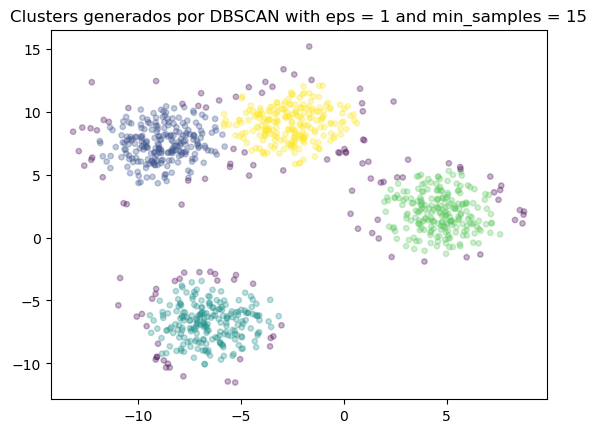

In [29]:
# DBSCAN increasing min_samples
dbscan = cluster.DBSCAN(eps=1, min_samples = 15)

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generados por DBSCAN with eps = 1 and min_samples = 15")
plt.show()

We have successfully "reconstructed" the four groups, but as expected, this came at the cost of increasing the number of points considered noise. Let's see how many we have now:

In [30]:
clusters, counts = np.unique(result_dbscan, return_counts=True)

# Create a dictionary with the data:
cluster_counts = dict(zip(clusters, counts))

print("Data points per cluster:", cluster_counts)

Data points per cluster: {-1: 117, 0: 223, 1: 216, 2: 221, 3: 223}


We have increased from 26 to 117 points considered noise. At this point, it might be appropriate to evaluate the algorithm's effectiveness. But first, let's display the actual groups again:








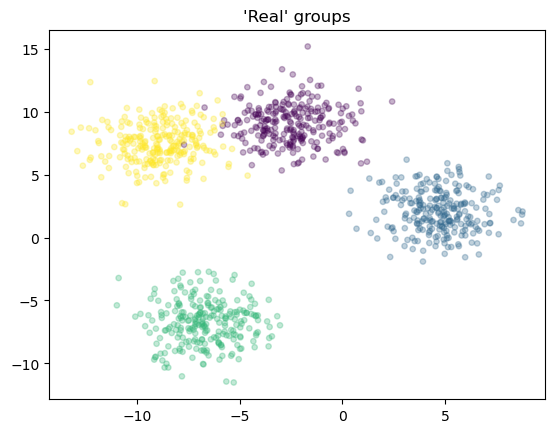

In [31]:
# Show the real groups for the dataset
plt.scatter(X[:,0], X[:,1], s=15, c=y, alpha=0.3)
plt.title("'Real' groups")
plt.show()

Now, let's calculate how many points from each actual group our algorithm has correctly assigned. Before that, let's rename the clusters and display them:

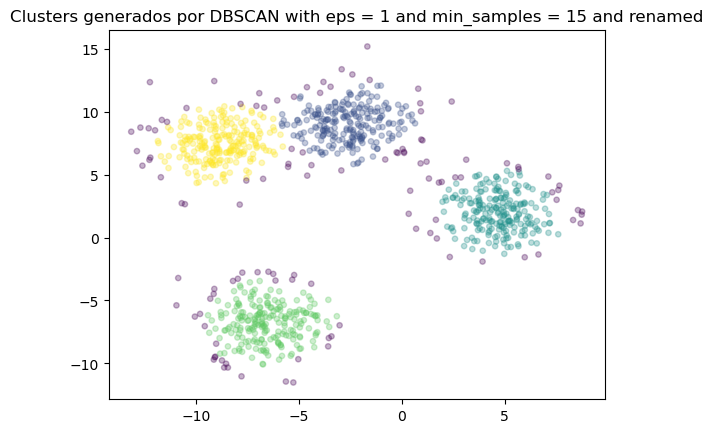

In [32]:
dbscan = cluster.DBSCAN(eps=1, min_samples = 15)

result_dbscan = dbscan.fit_predict(X)

# Rename clusters
label_mapping = {0: 13, 1: 12, 2: 11, 3: 10}
for old_label, new_label in label_mapping.items():
    result_dbscan[result_dbscan == old_label] = new_label
    
label_mapping = {13: 3, 12: 2, 11: 1, 10: 0}
for old_label, new_label in label_mapping.items():
    result_dbscan[result_dbscan == old_label] = new_label

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generados por DBSCAN with eps = 1 and min_samples = 15 and renamed")
plt.show()

Now, let’s calculate how many points have been assigned to the correct group:

In [33]:
# And calculate the percentage of coincidences between the two:
coincidence = np.mean(y == result_dbscan) * 100
coincidence

87.9

The algorithm has correctly assigned points 87.9% of the time. Based on this, let's try to fine-tune the eps and min_samples values to see if we can improve it slightly. Considering that this is not the ideal algorithm for this dataset, it's unlikely we'll achieve as good a result as with k-means. However, we can leverage our understanding of the parameters we can adjust.

We know that eps is related to the distance between points. Currently, with the parameters used in the previous attempt (eps=1 and min_samples=15), there were 117 unassigned samples. By increasing eps just up to the point where the algorithm still generates 4 clusters (our target) instead of merging into 3, we can reduce the number of unassigned samples. Let’s see how far we can go by increasing eps and what percentage of samples are correctly assigned:

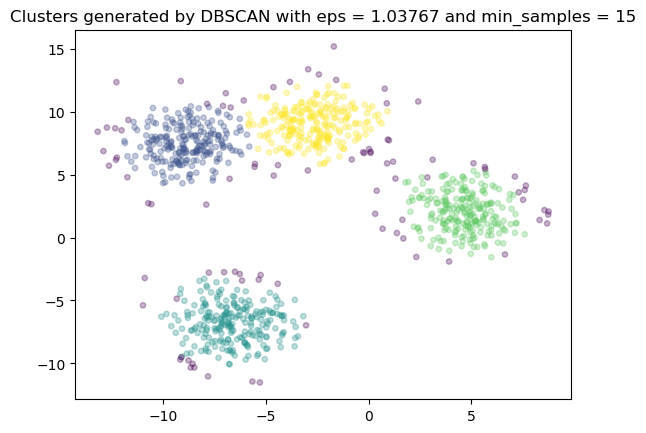

In [34]:
# DBSCAN increasing min_samples
dbscan = cluster.DBSCAN(eps=1.03767, min_samples = 15)

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with eps = 1.03767 and min_samples = 15")
plt.show()

We could only slightly increase the value of eps, as the algorithm is particularly sensitive to this modification. On the other hand, reducing min_samples quickly causes the algorithm to jump from 4 clusters to 3, so it has been kept at the value of 15. Let’s see how many samples remain unassigned with these values:

In [35]:
clusters, counts = np.unique(result_dbscan, return_counts=True)

# Create a dictionary with the data:
cluster_counts = dict(zip(clusters, counts))

print("Data points per cluster:", cluster_counts)

Data points per cluster: {-1: 91, 0: 226, 1: 229, 2: 225, 3: 229}


Hemos conseguido reducir estas muestras a 91. Veamos qué porcentaje de puntos se asignan al grupo correcto. Primero renombramos las etiquetas de los clústers y después calculamos ese porcentaje:

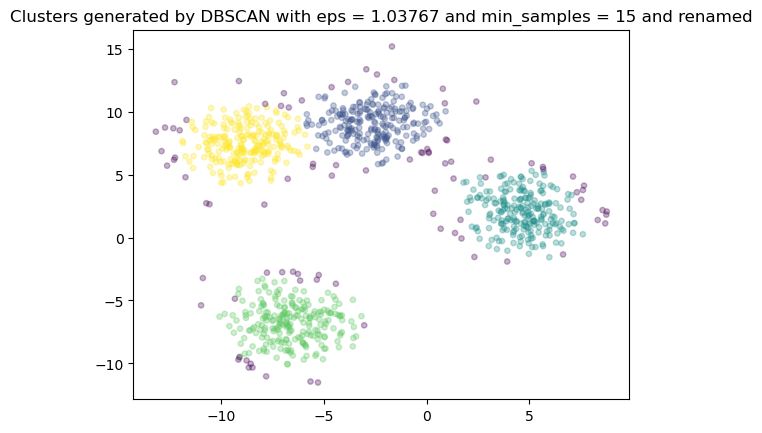

In [36]:
dbscan = cluster.DBSCAN(eps=1.03767, min_samples = 15)

result_dbscan = dbscan.fit_predict(X)

# Rename clusters
label_mapping = {0: 13, 1: 12, 2: 11, 3: 10}
for old_label, new_label in label_mapping.items():
    result_dbscan[result_dbscan == old_label] = new_label
    
label_mapping = {13: 3, 12: 2, 11: 1, 10: 0}
for old_label, new_label in label_mapping.items():
    result_dbscan[result_dbscan == old_label] = new_label

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with eps = 1.03767 and min_samples = 15 and renamed")
plt.show()

In [37]:
# And calculate the percentage of coincidences between the two::
coincidenc = np.mean(y == result_dbscan) * 100
coincidenc

90.4

We see that we have managed to reach 90.4% of samples correctly assigned to their group. Even so, using DBSCAN and tweaking eps and min_samples, we are still far from the result achieved with k-means.

As we have seen, DBSCAN uses a different approach from k-means to, first, determine the number of clusters (in DBSCAN, this number is not a parameter), and second, assign points to those clusters. Since DBSCAN is density-based rather than relying on the distance to a centroid, in datasets like Blobs, the algorithm detects points that are far from the centers of the groups as noise and does not assign them to any cluster. The density problem did not affect K-means, which is why that algorithm was not hindered by points far from the cluster centers.

## 1.2.2. DBSCAN with Moons dataset

Let's start again using the default parameters:

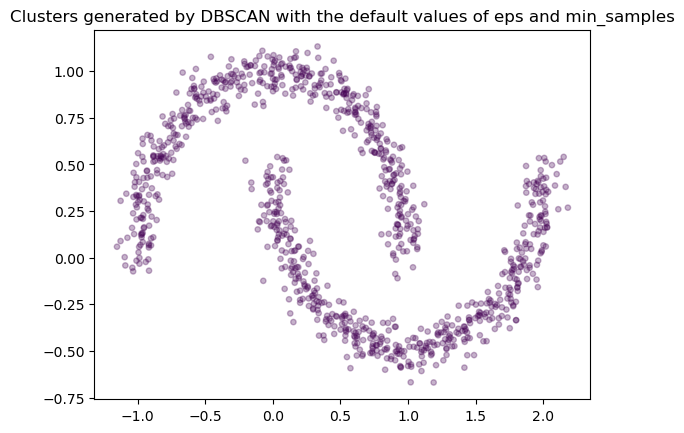

In [38]:
# Load Moons dataset as variables
X, y = X_moons, y_moons

# DBSCAN with default parameters
dbscan = cluster.DBSCAN()

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with the default values of eps and min_samples")
plt.show()

We can see that with the default parameters, we are unable to separate the points into anything resembling the actual groups. Let's check if there are any points that have not been assigned to any cluster:

In [40]:
np.unique(result_dbscan)

array([0], dtype=int64)

All the values are assigned to cluster 0. This can help us understand what's happening and how to improve the algorithm's performance. First, we need to consider that the eps parameter in DBSCAN is related to the distance between points, so it's important to look at the scales of this plot and the blobs plot. If we do that, we can see that in the case of Moons, all the points are contained within a smaller space. So, we could try reducing eps and see what effect it has on the algorithm::

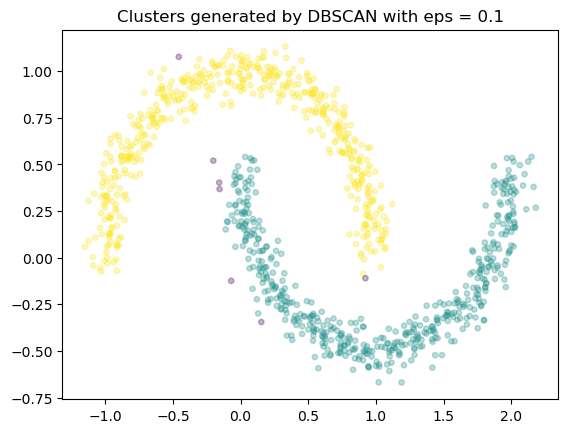

In [41]:
# DBSCAN reducing eps to 0.1
dbscan = cluster.DBSCAN(eps=0.1)

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with eps = 0.1")
plt.show()

We’re almost there. We can clearly see two well-separated groups, and the number of outliers seems small. Before proceeding, let’s check if there are any unassigned points and what percentage of the samples have been correctly assigned. Let’s start with the unassigned points:








In [42]:
clusters, counts = np.unique(result_dbscan, return_counts=True)

# Create a dictionary with the data:
cluster_counts = dict(zip(clusters, counts))

print("Data points per clúster:", cluster_counts)

Data points per clúster: {-1: 7, 0: 495, 1: 498}


We can see that we have only 7 unassigned points out of the 1000 in the dataset. Now, before calculating the percentage of points assigned to the correct group, let’s review the actual groups again:

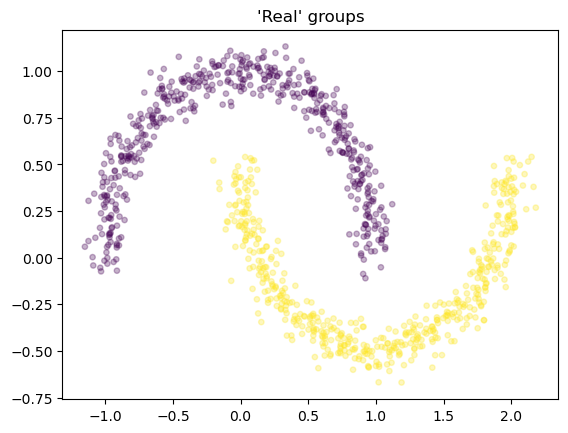

In [43]:
# Show the real groups of the dataset
plt.scatter(X[:,0], X[:,1], s=15, c=y, alpha=0.3)
plt.title("'Real' groups")
plt.show()

Now, let's calculate the percentage of samples that have been correctly assigned to their respective groups:

In [45]:
# Rename the clusters generated by DBSCAN
result_dbscan_rename = np.where(result_dbscan == 0, 1, np.where(result_dbscan == 1, 0, result_dbscan))

# And calculate the percentage of coincidences between the two:
coincidence = np.mean(y == result_dbscan_rename) * 100
coincidence

99.3

We have a correct sample assignment rate of 99.3%. Now, let’s see if we can slightly improve this result. It seems that the main issue we have at the moment is those 7 unassigned points. Following the same logic as with the blobs dataset, the idea could be to either increase eps to try to "capture" those points into one of the clusters or reduce min_samples. After conducting some tests, here’s the most optimal result found:

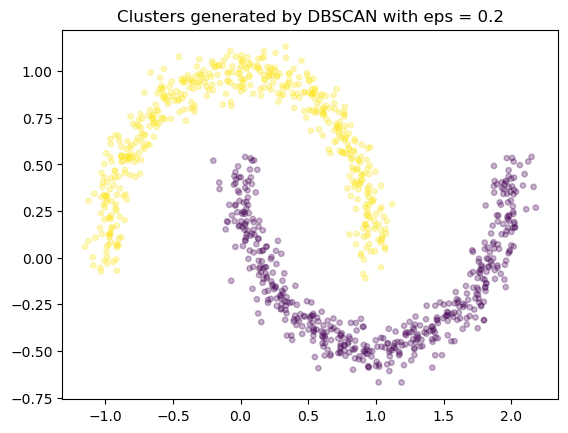

In [46]:
# DBSCAN increasing eps to 0.2
dbscan = cluster.DBSCAN(eps=0.2)

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with eps = 0.2")
plt.show()

Let´s see if we have unassigned data points:

In [49]:
clusters, counts = np.unique(result_dbscan, return_counts=True)

# Create a dictionary with the clusters:
cluster_counts = dict(zip(clusters, counts))

print("Data points per clúster:", cluster_counts)

Data points per clúster: {0: 500, 1: 500}


Now, all the points are assigned. Let's see the percentage of samples that have been correctly assigned:

In [50]:
# Rename the clusters generated by DBSCAN
result_dbscan_rename = np.where(result_dbscan == 0, 1, np.where(result_dbscan == 1, 0, result_dbscan))

# And calculate the percentage of coincidence between the two:
coincidence = np.mean(y == result_dbscan_rename) * 100
coincidence

100.0

We used the Moons dataset to better understand the differences in behavior between K-means and DBSCAN. By understanding DBSCAN's parameters, we were able to generate a point-to-cluster assignment identical to the actual groups by adjusting the distance parameter and considering the scale of this dataset compared to the blobs dataset. In this case, we didn't encounter as many issues with DBSCAN and outliers, likely because in the moons dataset, the points are more concentrated than in blobs.

Thus, we can understand that DBSCAN's sensitivity to outliers, which we saw in blobs, is compensated for in the case of moons by its better performance with non-circular or non-spherical clusters, which are better suited for DBSCAN than for K-means. Ultimately, the key takeaway is to understand the distributions of points and select the most appropriate algorithm for each case.

## 1.2.3. DBSCAN with Circles dataset

Let's start again using the default parameters:

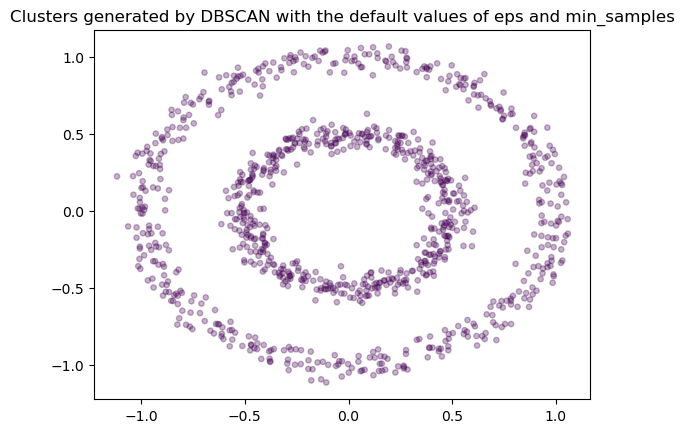

In [52]:
# Load Circles dataset as variables
X, y = X_circles, y_circles

# DBSCAN with default parameters
dbscan = cluster.DBSCAN()

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with the default values of eps and min_samples")
plt.show()

As in the case of the moons dataset, DBSCAN's default parameters result in a single group, with no unassigned points:

In [53]:
np.unique(result_dbscan)

array([0], dtype=int64)

To improve the result, let's again consider the distribution of points and the scale. First, we can see that the scale is even smaller than in the moons dataset. Therefore, our initial approach will be to reduce the value of eps and see if this results in a greater number of clusters:

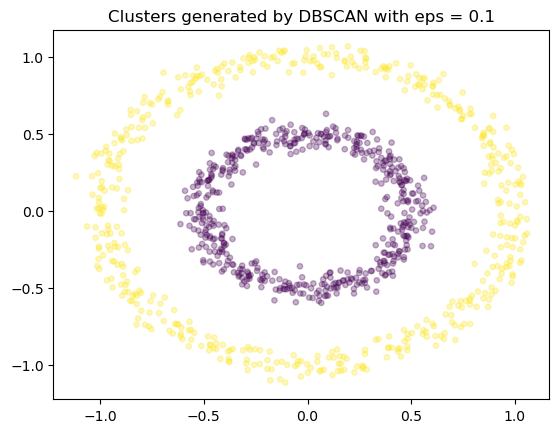

In [54]:
# DBSCAN reducing eps to 0.1
dbscan = cluster.DBSCAN(eps=0.1)

result_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], s=15, c=result_dbscan, alpha=0.3)
plt.title("Clusters generated by DBSCAN with eps = 0.1")
plt.show()

Once again, it seems that by simply reducing the value of eps, we have obtained clusters that closely resemble the actual groups. Let’s check if there are any unassigned values:

In [55]:
clusters, counts = np.unique(result_dbscan, return_counts=True)

# Create a dictionary with the data:
cluster_counts = dict(zip(clusters, counts))

print("Data points per clúster:", cluster_counts)

Data points per clúster: {0: 500, 1: 500}


There are no unassigned values, so let’s calculate the percentage of correctly assigned samples. First, let’s display the actual groups:

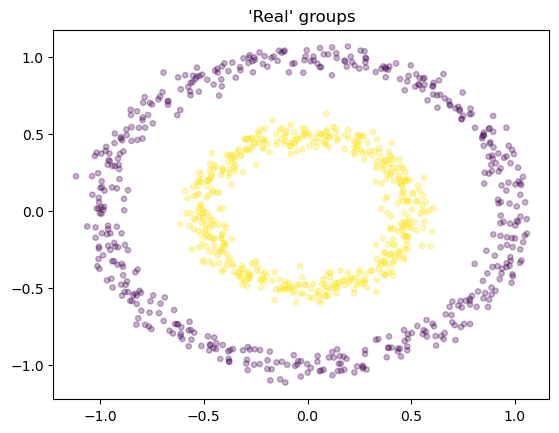

In [56]:
# Show the real groups for the dataset
plt.scatter(X[:,0], X[:,1], s=15, c=y, alpha=0.3)
plt.title("'Real' groups")
plt.show()

Now, let’s calculate the percentage of correctly assigned samples:

In [57]:
# Rename the DBSCAN generated clusters
result_dbscan_rename = np.where(result_dbscan == 0, 1, np.where(result_dbscan == 1, 0, result_dbscan))

# Calculate the percentage of coincidence between the two:
coincidence = np.mean(y == result_dbscan_rename) * 100
coincidence

100.0

As with the moons dataset, DBSCAN performs very well with datasets like circles. The reasoning is similar: circles is a dataset without outliers that are far removed from the distributions. Additionally, the density of points is relatively uniform across the two circles, and there are large gaps between the circles without any points.

Regarding the parameters we've used, after observing the default parameters and their effects on cluster generation, we can deduce the necessary adjustments by simply considering the scale of the space where the points are located. In this case, as with moons, we only needed to reduce the value of eps. All points were then correctly assigned, with none left unassigned.

## 1.3. Hierarchical algorithms

As opposed to K-means or DBSCAN, hierarchical algorithms follow a sequential approach when clustering data. Depending on the type of the algorithm, they start from a non-clustered initial state, and subsequently divide the points in smaller clusters (*top-down* approach) or start by a fully-divided initial state and join together data points in increasingly larger clusters. There are different metrics (e.g. distance metrics) that the algorithms employ to perform this function, but the end point is always a hierarchical structure where more similar data points are closer than more different data points. The definition of unique clusters is more loose with hierarchical algorithms.

Here the implementation of hierarchical clustering with the datasets we have been using:

In [58]:
# Import library
from scipy.cluster import hierarchy

# Load dataset Blobs as variables
X, y = X_blobs, y_blobs

Let’s generate different hierarchical clusters using various linkage criteria to understand their effects on cluster generation. Since our goal is to explore the impact of different linkage criteria, we’ll avoid modifying other parameters (e.g., metric). Additionally, to keep the exercise concise, we’ll focus on the first four linkage criteria provided by hierarchy.linkage (*single, complete, average, centroid*), as discussed in the module resources.

For each linkage criterion:

1. Generate and display the dendrogram: We’ll analyze the most noticeable patterns in the dendrogram.
2. Visualize cluster assignments: Using the cut_tree method, we’ll set the number of clusters to 4 (since we know the dataset contains 4 groups) and display the resulting cluster assignments.
Let’s start with the *single linkage* criterion.

In [ ]:
# Single linkage criterion
Z = hierarchy.linkage(X, 'single')

# Show the dendrogram
fig = plt.figure(figsize=(25, 10))
plt.title("Dendrogram for the single linkage criterion", fontsize=24)
dn = hierarchy.dendrogram(Z)